In [89]:
from gorgo import infer, condition, draw_from, flip, keep_deterministic, mem, factor
from gorgo.hashable import hashabledict
from gorgo.distributions.builtin_dists import Uniform, Beta
from gorgo.distributions import Mixture

from model import Utterance, Instance, Kind, meaning, literal_listener, speaker, pragmatic_listener

import numpy as np
from gorgo.inference import MaximumMarginalAPosteriori
import pickle

from collections import namedtuple
import math
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy.stats import pearsonr

In [ ]:
# helper functions

## convert gorgo dist to df for plotting
@keep_deterministic
def dist_to_df(dist):
    df_dist = pd.DataFrame()
    if isinstance(dist.support[0], float): 
        df_dist['Element'] = pd.DataFrame(dist.support)
    else: 
        # df can't support multiple keys
        df_dist = pd.DataFrame(dist.support)
    df_dist['Probability'] = dist.probabilities
    return df_dist

# Study 8 (proportionality)

In [4]:
# define all training trials
generic_trials = [
    (Utterance("Zarpies", "love to eat flowers"), Instance("Zarpie", ("love to eat flowers", ))),
    (Utterance("Zarpies", "have stripes in their hair"), Instance("Zarpie", ("have stripes in their hair", ))),
    (Utterance("Zarpies", "can bounce a ball on their heads"), Instance("Zarpie", ("can bounce a ball on their heads", ))),
    (Utterance("Zarpies", "like to sing"), Instance("Zarpie", ("like to sing", ))),
    (Utterance("Zarpies", "climb tall fences"), Instance("Zarpie", ("climb tall fences", ))),
    (Utterance("Zarpies", "flap their arms when they are happy"), Instance("Zarpie", ("flap their arms when they are happy", ))),
    (Utterance("Zarpies", "have freckles on their feet"), Instance("Zarpie", ("have freckles on their feet", ))),
    (Utterance("Zarpies", "hop over puddles"), Instance("Zarpie", ("hop over puddles", ))),
    (Utterance("Zarpies", "really don't like walking in the mud"), Instance("Zarpie", ("really don't like walking in the mud", ))),
    (Utterance("Zarpies", "draw stars on their knees"), Instance("Zarpie", ("draw stars on their knees", ))),
    (Utterance("Zarpies", "can flip in the air"), Instance("Zarpie", ("can flip in the air", ))),
    (Utterance("Zarpies", "are scared of ladybugs"), Instance("Zarpie", ("are scared of ladybugs", ))),
    (Utterance("Zarpies", "really don't like ice cream"), Instance("Zarpie", ("really don't like ice cream", ))),
    (Utterance("Zarpies", "chase shadows"), Instance("Zarpie", ("chase shadows", ))),
    (Utterance("Zarpies", "babies are wrapped in orange blankets"), Instance("Zarpie", ("babies are wrapped in orange blankets", ))),
    (Utterance("Zarpies", "sleep in tall trees"), Instance("Zarpie", ("sleep in tall trees", )))
]

specific_trials = [
    (Utterance("This Zarpie", "love to eat flowers"), Instance("Zarpie", ("love to eat flowers", ))),
    (Utterance("This Zarpie", "have stripes in their hair"), Instance("Zarpie", ("have stripes in their hair", ))),
    (Utterance("This Zarpie", "can bounce a ball on their heads"), Instance("Zarpie", ("can bounce a ball on their heads", ))),
    (Utterance("This Zarpie", "like to sing"), Instance("Zarpie", ("like to sing", ))),
    (Utterance("This Zarpie", "climb tall fences"), Instance("Zarpie", ("climb tall fences", ))),
    (Utterance("This Zarpie", "flap their arms when they are happy"), Instance("Zarpie", ("flap their arms when they are happy", ))),
    (Utterance("This Zarpie", "have freckles on their feet"), Instance("Zarpie", ("have freckles on their feet", ))),
    (Utterance("This Zarpie", "hop over puddles"), Instance("Zarpie", ("hop over puddles", ))),
    (Utterance("This Zarpie", "really don't like walking in the mud"), Instance("Zarpie", ("really don't like walking in the mud", ))),
    (Utterance("This Zarpie", "draw stars on their knees"), Instance("Zarpie", ("draw stars on their knees", ))),
    (Utterance("This Zarpie", "can flip in the air"), Instance("Zarpie", ("can flip in the air", ))),
    (Utterance("This Zarpie", "are scared of ladybugs"), Instance("Zarpie", ("are scared of ladybugs", ))),
    (Utterance("This Zarpie", "really don't like ice cream"), Instance("Zarpie", ("really don't like ice cream", ))),
    (Utterance("This Zarpie", "chase shadows"), Instance("Zarpie", ("chase shadows", ))),
    (Utterance("This Zarpie", "babies are wrapped in orange blankets"), Instance("Zarpie", ("babies are wrapped in orange blankets", ))),
    (Utterance("This Zarpie", "sleep in tall trees"), Instance("Zarpie", ("sleep in tall trees", )))
]

# test feature labels for plotting
feature_labels = {
    'live_caves': 'live in caves',
    'ride_lions': 'ride lions',
    'farm_potatoes': 'farm potatoes',
    'play_banjo': 'play banjos',
    'look_left': 'look to their left when spoken to',
    'clap_three': 'clap three times before entering a room',
    'smile_sad': 'smile when they are sad',
    'chug_syrup': 'chug maple syrup',
    'yell_cats': 'yell at stray cats',
    'go_opera': 'go to the opera',
    'dance_fire': 'dance around a fire on their 10th birthday',
    'sing_songs': 'sing beautiful songs',
    'scream_windows': 'scream out windows',
    'smell_garbage': 'smell garbage for fun',
    'wash_ponds': 'wash their clothes in ponds',
    'paint_hands': 'paint their hands yellow'
}


In [77]:
# assemble list of conditions
conditions = []
for num_generics in (0, 4, 8, 12, 16):
    for total_utt in (0, 4, 8, 12, 16):
        if num_generics > total_utt:
            # invalid
            continue
        else:
            # add to list of conditions
            new_row = {"num_generics": num_generics, 
                       "total_utt": total_utt}
            try:
                new_row["prop"] = num_generics/total_utt
            except ZeroDivisionError:
                new_row["prop"] = ''
            
            # make training structure
            num_specifics = total_utt - num_generics
            new_row['training_structure'] = "G" * num_generics + "S" * num_specifics
            
            # get the first num_generics generics and last num_specifics specifics --> exact trial order doesn't matter for the model
            new_row['training_trials'] = tuple(generic_trials[:num_generics] + (specific_trials[-num_specifics:] if num_specifics > 0 else []))
            
            conditions.append(new_row) 
            
conditions = pd.DataFrame(conditions)

In [ ]:
# # fix inverse temperature at something reasonable
# inv_temp = 20 # could try fiddling with this
    
# # assemble list of dicts
# conditions_coherence = []
# for num_generics in (0, 4, 8, 12, 16):
#     for total_utt in (0, 4, 8, 12, 16):
#         if num_generics > total_utt:
#             # invalid
#             continue
#         else:
#             dist_coherence = pragmatic_listener(
#                 # look up training trials for that condition
#                 conditions.loc[(conditions['num_generics'] == num_generics) & 
#                                (conditions['total_utt'] == total_utt), 
#                                'training_trials'].item(),
#                 inv_temp = inv_temp,
#                 only_return_coherence = True)
#             new_row = {'num_generics': num_generics, 
#                        'total_utt': total_utt,
#                        'dist': dist_coherence}
#             conditions_coherence.append(new_row) 

# # store output so we don't have to re-run each time
# with open("scratch/study 7/conditions_coherence_inv-temp-20.pkl", "wb") as f:
#     pickle.dump(conditions_coherence, f)

In [96]:
# read back in
with open("scratch/study 7/conditions_coherence_inv-temp-20.pkl", "rb") as f: 
    conditions_coherence = pickle.load(f)
    
conditions_coherence

[{'num_generics': 0,
  'total_utt': 0,
  'dist': DiscreteInferenceResult(support=(0.1, 0.3, 0.7, 0.9, 0.6, 0.8, 0.5, 0.2, 0.4), probabilities=(np.float64(0.1111111111111111), np.float64(0.1111111111111111), np.float64(0.1111111111111111), np.float64(0.1111111111111111), np.float64(0.1111111111111111), np.float64(0.1111111111111111), np.float64(0.1111111111111111), np.float64(0.1111111111111111), np.float64(0.1111111111111111)))},
 {'num_generics': 0,
  'total_utt': 4,
  'dist': DiscreteInferenceResult(support=(0.1, 0.3, 0.7, 0.9, 0.6, 0.8, 0.5, 0.2, 0.4), probabilities=(np.float64(0.42785633841246323), np.float64(0.15659869870401036), np.float64(0.005287973743590956), np.float64(6.549867346861295e-05), np.float64(0.016705736414720077), np.float64(0.001045397415941735), np.float64(0.040775425429765234), np.float64(0.26712691917474485), np.float64(0.08453801203129509)))},
 {'num_generics': 0,
  'total_utt': 8,
  'dist': DiscreteInferenceResult(support=(0.1, 0.3, 0.7, 0.9, 0.6, 0.8, 0.5, 

In [97]:
# convert to df for plotting
df_conditions_coherence = []

# explode gorgo dist into element and probability
for condition in conditions_coherence:
    for x in range(len(condition['dist'].support)):
        new_dict = {}
        new_dict['num_generics'] = condition['num_generics']
        new_dict['total_utt'] = condition['total_utt']
        new_dict['coherence'] = condition['dist'].support[x]
        new_dict['probability'] = condition['dist'].probabilities[x]
        df_conditions_coherence.append(new_dict)

df_conditions_coherence = pd.DataFrame(df_conditions_coherence)

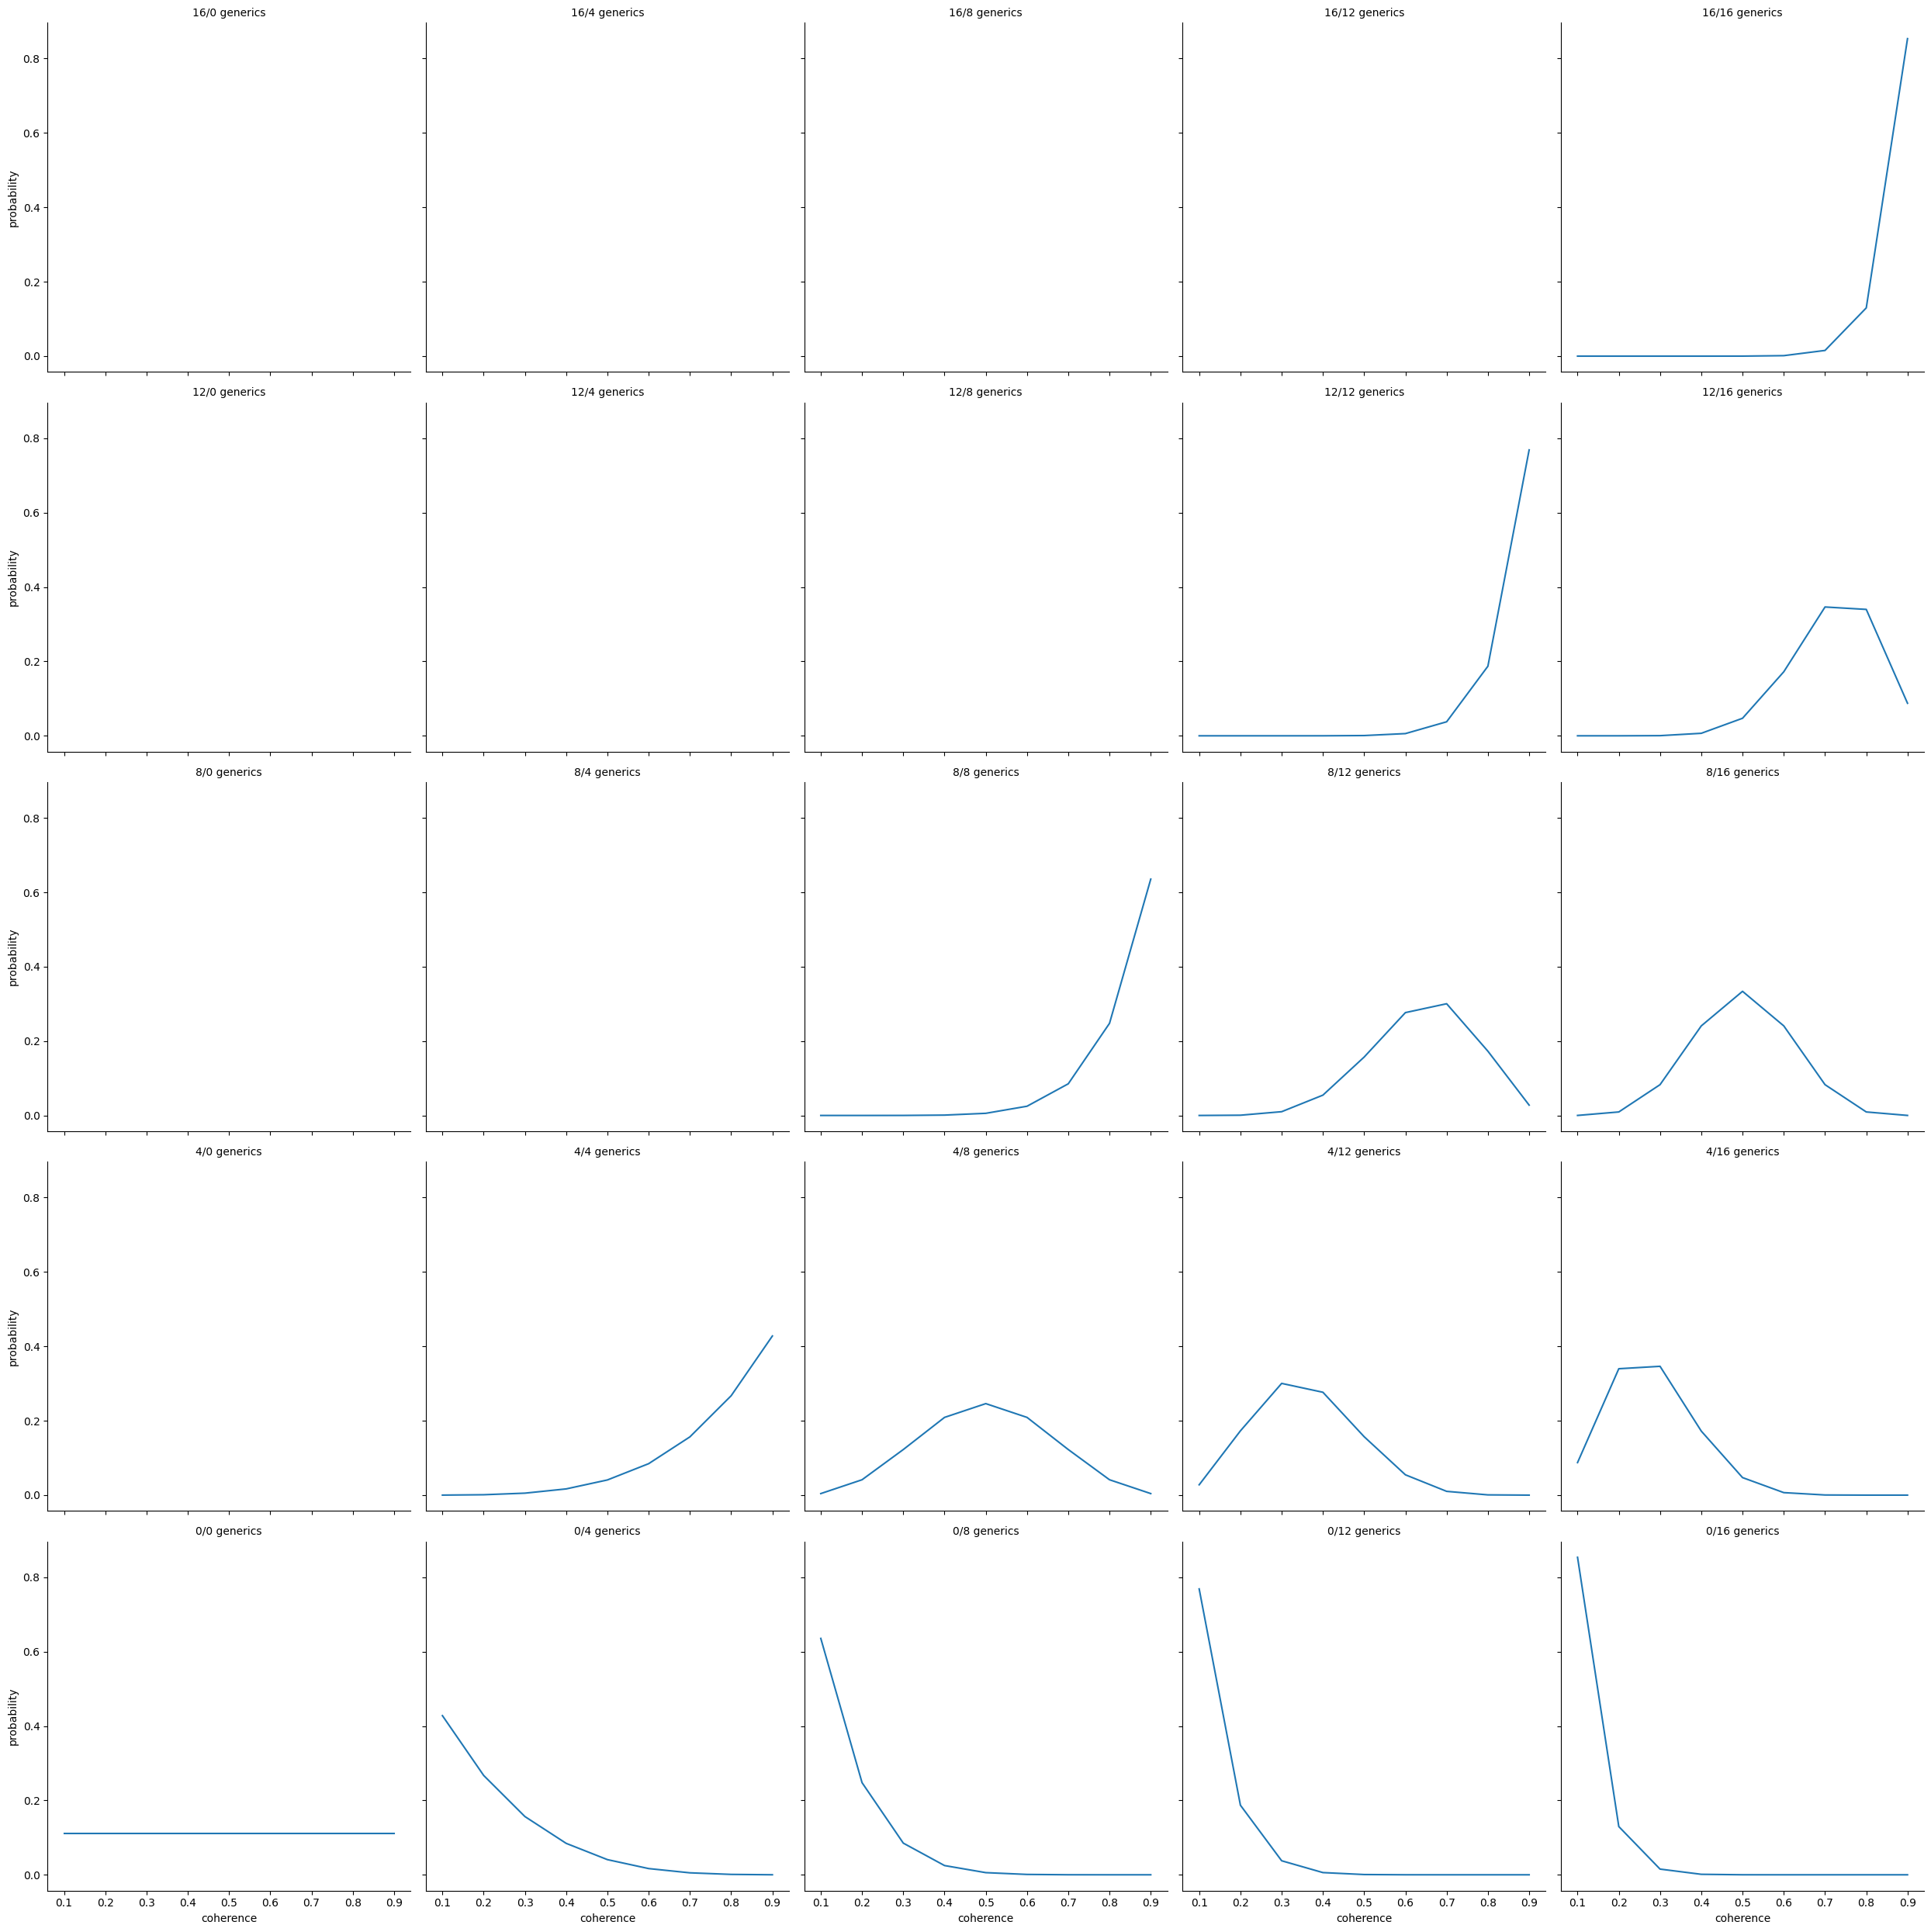

In [98]:
# plot coherence
g = sns.relplot(data = df_conditions_coherence,
                x='coherence', y='probability',
                row='num_generics', row_order=list(reversed(df_conditions_coherence['num_generics'].unique())),
                col='total_utt', 
                kind='line')
g.set_titles(template = "{row_name}/{col_name} generics")

# save
plt.savefig("figs/study 7/predictions_coherence.png", bbox_inches = "tight")

In [93]:
conditions_coherence_ev = []

# for each condition, get coherence expected values
for num_generics in (0, 4, 8, 12, 16):
    for total_utt in (0, 4, 8, 12, 16):
        if num_generics > total_utt:
            # invalid condition
            continue
        else:
            # get coherence dist for the condition
            for condition in conditions_coherence:
                if condition['num_generics'] == num_generics and condition['total_utt'] == total_utt:
                    dist_coherence = condition['dist']
                    break
            # get expected value of coherence
            new_row = {'num_generics': num_generics, 
                       'total_utt': total_utt,
                       'coherence_ev': dist_coherence.expected_value()}
            # add to list
            conditions_coherence_ev.append(new_row)

conditions_coherence_ev = pd.DataFrame(conditions_coherence_ev)

In [94]:
conditions_coherence_ev

,num_generics,total_utt,coherence_ev
0,0,0,0.500000
1,0,4,0.226281
2,0,8,0.160258
3,0,12,0.133707
4,0,16,0.120226
5,4,4,0.784210
6,4,8,0.531448
7,4,12,0.373461
8,4,16,0.285292
9,8,8,0.845754


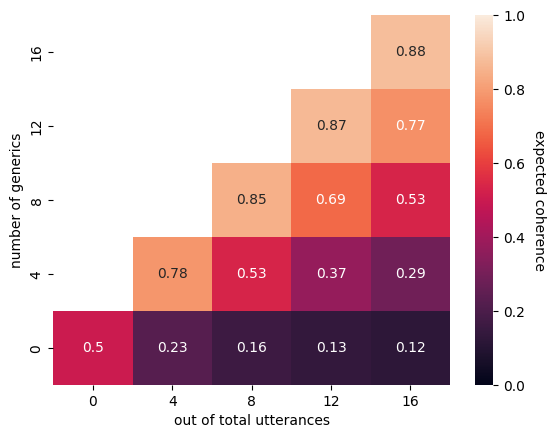

In [95]:
# plot coherence EV
g = sns.heatmap(data = conditions_coherence_ev.pivot(
    index="num_generics", columns="total_utt", values="coherence_ev"),
                vmin=0, vmax=1,
                annot=True)
# y-axis
g.invert_yaxis()
plt.ylabel("number of generics")
# x-axis
plt.xlabel("out of total utterances")

# legend
cbar = g.collections[0].colorbar
cbar.set_label('expected coherence', rotation=270, labelpad=15)

# save
plt.savefig("figs/study 7/predictions_coherence_ev.png", bbox_inches = "tight")
